In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Load and preprocess data
df = pd.read_csv('loan_repayment_data.csv', parse_dates=['Funded_date', 'due_date', 'last_paid_date'])

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Information:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

First few rows of the dataset:
   customer_id  loan_id new_repeat Funded_date   due_date  loan_duration  \
0        27210    36747     REPEAT  2018-11-16 2018-12-16             30   
1        23510    21936     REPEAT  2018-10-05 2018-11-04             30   
2        20035    17740        NEW  2018-09-20 2018-10-20             30   
3        12293    17142        NEW  2018-09-18 2018-10-18             30   
4         1775     5070     REPEAT  2017-08-29 2017-09-28             30   

   loan_amount  to_repay  interest_amount  repaid_amount  loan_balance  \
0         1750      1975              175            700          1275   
1          500       600               50            100           500   
2          500       600               50            200           400   
3         2000      2280              200             48          2232   
4         3000      3450              300           1050          2400   

  last_paid_date  
0     2019-11-25  
1     2019-05-23  
2     2019

In [35]:
# Summary statistics for numerical columns
# List of columns of interest
columns = [
    'loan_duration',
    'loan_amount',
    'to_repay',
    'interest_amount',
    'repaid_amount',
    'loan_balance'
]

# Display summary statistics
summary_stats = df[columns].describe()
print(summary_stats.round(2)) 

       loan_duration  loan_amount  to_repay  interest_amount  repaid_amount  \
count           61.0        61.00     61.00            61.00          61.00   
mean            30.0      1382.79   1592.74           139.80        1080.54   
std              0.0      1086.16   1218.58           102.73         785.29   
min             30.0       500.00    580.00            40.00          48.00   
25%             30.0       500.00    600.00            50.00         600.00   
50%             30.0      1000.00   1150.00           100.00         625.00   
75%             30.0      2000.00   2280.00           200.00        1700.00   
max             30.0      6000.00   6600.00           540.00        2280.00   

       loan_balance  
count         61.00  
mean         515.31  
std         1190.84  
min            0.00  
25%            0.00  
50%            0.00  
75%          400.00  
max         6100.00  


### Insights

- All loans are short-term (30 days) with interest ranging from 40.00 - 540.00 where the averga interest is 139.80
- Loan amounts range from 500.00 to 6000.00. Half of the loans are below 1000.00, and 75% are below 2000.00, suggesting most loans are small to medium-sized.
-  The repayment amounts reflects interst ranging from 580.00 to 6600.00 with a mean of 1592.74. This amount is generally higher than the loan amount.
- 50% of loans have repaid amounts below 625.00, indicating partial repayments are common. These amounts range from 48.00 to 2280.00.
- Half of the the loans have been repaid (balance of 0.00). A small portion of loans has high balances, suggesting some borrowers struggle to repay.

In [36]:
# Feature engineering
df['loan_status'] = np.where(df['loan_balance'] == 0, 'Fully Repaid', 'Outstanding')
df['days_past_due'] = (df['last_paid_date'] - df['due_date']).dt.days
df['repayment_ratio'] = df['repaid_amount'] / df['to_repay']
df['interest_rate'] = df['interest_amount'] / df['loan_amount']
df['loan_size_category'] = pd.cut(df['loan_amount'],
                                 bins=[0, 1000, 5000, 10000],
                                 labels=['Small', 'Medium', 'Large'])


In [51]:
# Customer Type Analysis
customer_analysis = df.groupby('new_repeat').agg({
    'loan_id': 'count',
    'loan_amount': 'mean',
    'repayment_ratio': 'mean',
    'days_past_due': 'mean',
    'loan_status': lambda x: (x == 'Fully Repaid').mean()
}).rename(columns={
    'loan_id': 'Total Loans',
    'loan_amount': 'Avg Loan Amount',
    'repayment_ratio': 'Avg Repayment Ratio',
    'days_past_due': 'Avg Days Past Due',
    'loan_status': 'Fully Repaid Rate'
})
print("\nCustomer Analysis:")
print(customer_analysis)







Customer Analysis:
            Total Loans  Avg Loan Amount  Avg Repayment Ratio  \
new_repeat                                                      
NEW                  54      1240.740741             0.872604   
REPEAT                7      2478.571429             0.207304   

            Avg Days Past Due  Fully Repaid Rate  
new_repeat                                        
NEW                 60.611111           0.833333  
REPEAT             102.571429           0.000000  


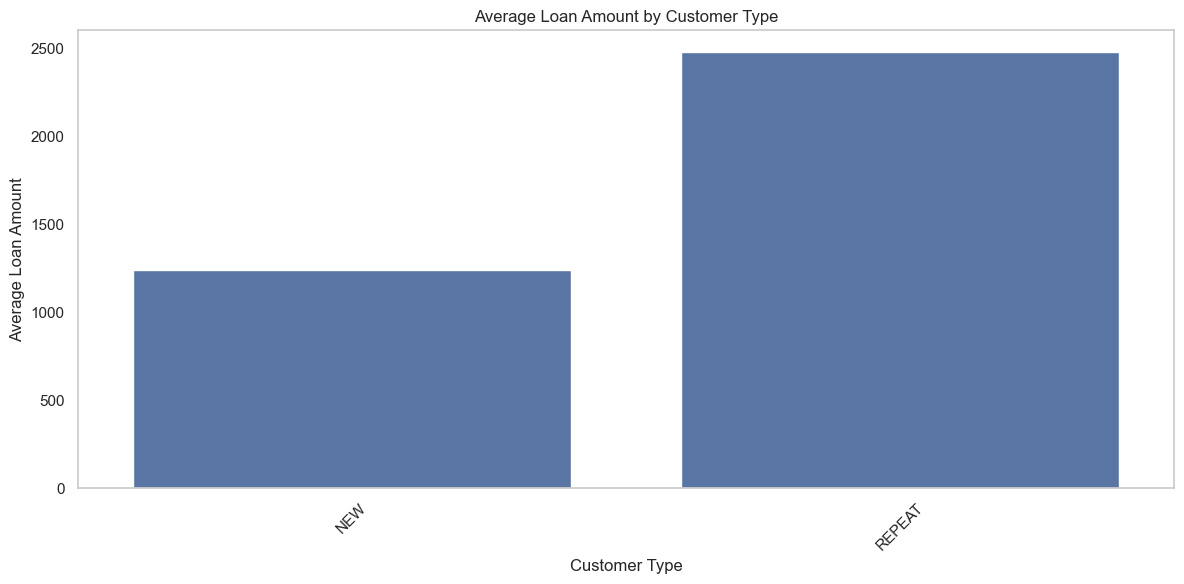

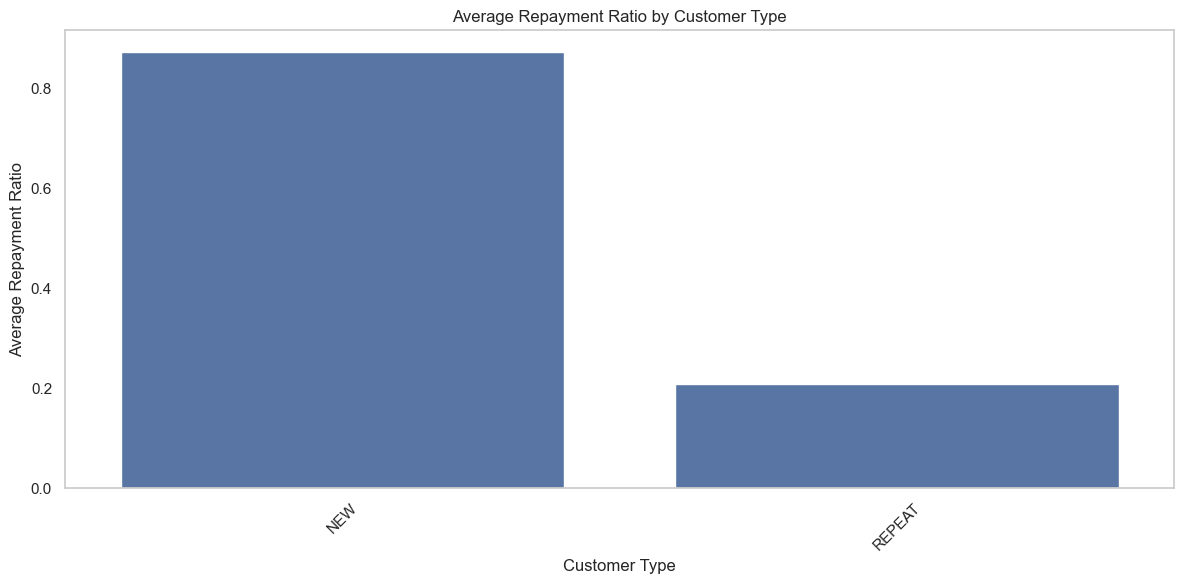

In [52]:
# Visualize customer type analysis
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_analysis.index, y='Avg Loan Amount', data=customer_analysis)
plt.title('Average Loan Amount by Customer Type')   
plt.xlabel('Customer Type')
plt.ylabel('Average Loan Amount')
plt.xticks(rotation=45)
plt.tight_layout()
# remove grid lines
plt.grid(False)
plt.show()
# Visualize repayment ratio by customer type
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_analysis.index, y='Avg Repayment Ratio', data=customer_analysis)
plt.title('Average Repayment Ratio by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Repayment Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
# remove grid lines
plt.grid(False)
plt.show()


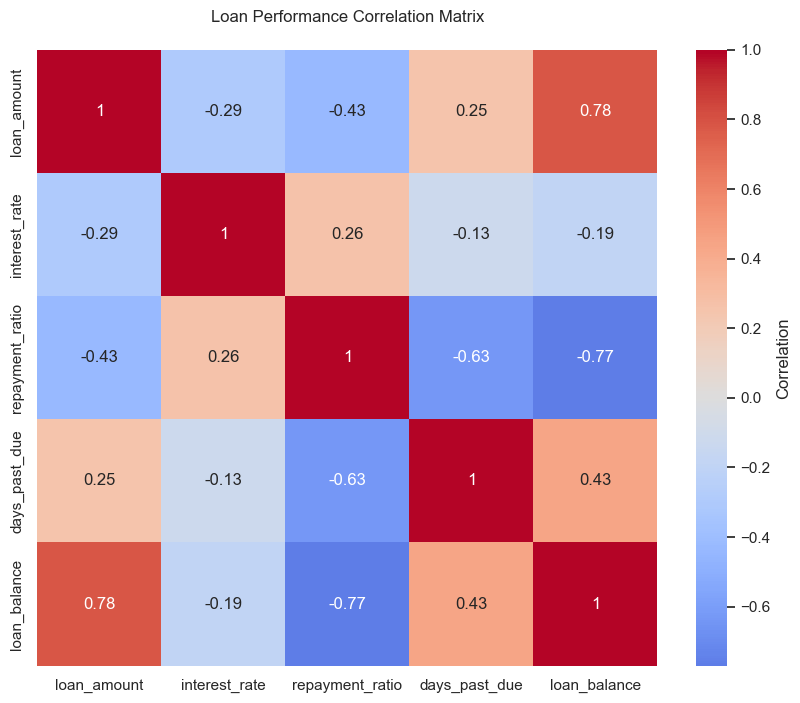

In [38]:
# Loan Performance 
plt.figure(figsize=(10, 8))
corr = df[['loan_amount', 'interest_rate', 'repayment_ratio', 
            'days_past_due', 'loan_balance']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
            annot_kws={"size": 12}, cbar_kws={'label': 'Correlation'})
plt.title('Loan Performance Correlation Matrix', pad=20)
plt.show()

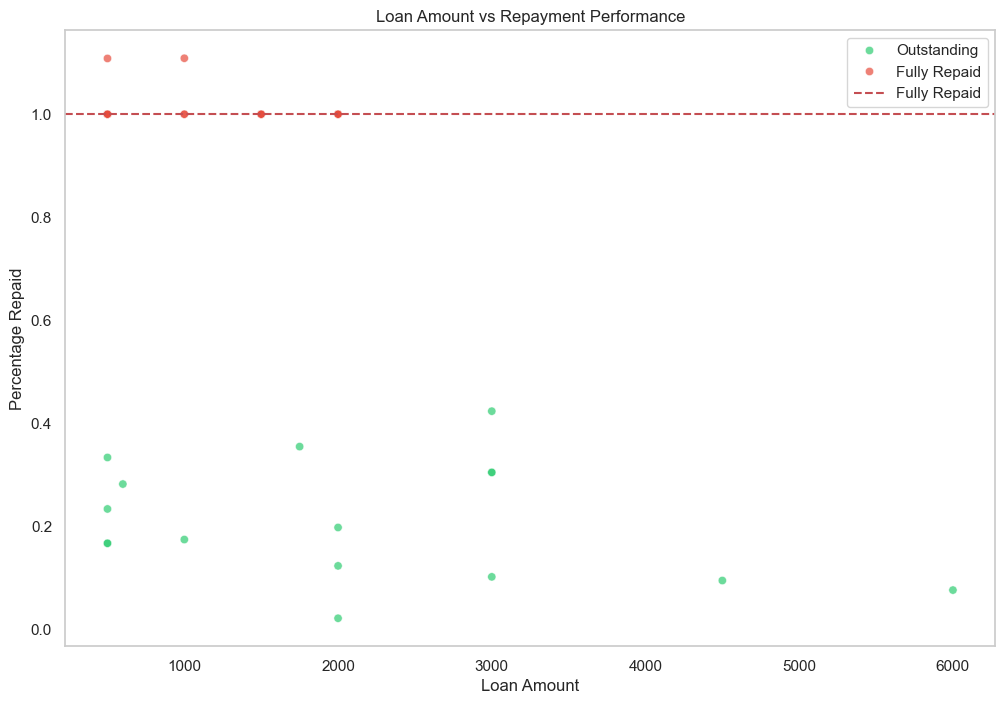

In [46]:
# Loan Amount vs repayment ratio
plt.figure(figsize=(12, 8))
sns.scatterplot(x='loan_amount', y='repayment_ratio', hue='loan_status', data=df, palette=['#2ecc71', '#e74c3c'], alpha=0.7)
plt.title('Loan Amount vs Repayment Performance')
plt.ylabel('Percentage Repaid')
plt.xlabel('Loan Amount')
plt.axhline(y=1, color='r', linestyle='--', label='Fully Repaid')
plt.legend()
plt.grid(False)
plt.show()



In [41]:

# Risk Analysis
# Identify risk flags
df['high_loan_flag'] = df['loan_amount'] > df['loan_amount'].quantile(0.75)
df['low_repayment_flag'] = df['repayment_ratio'] < 0.3
df['severe_delinquency'] = df['days_past_due'] > 30

risk_flags = pd.crosstab(
    index=[df['new_repeat'], df['loan_status']],
    columns=[df['high_loan_flag'], df['low_repayment_flag'], df['severe_delinquency']],
    margins=True
)
# Display risk flags
print(risk_flags)



    

high_loan_flag          False                  True                 All
low_repayment_flag      False       True      False       True         
severe_delinquency      False True False True False True False True    
new_repeat loan_status                                                 
NEW        Fully Repaid    45    0     0    0     0    0     0    0  45
           Outstanding      0    1     0    5     0    2     0    1   9
REPEAT     Outstanding      0    1     1    2     1    0     2    0   7
All                        45    2     1    7     1    2     2    1  61


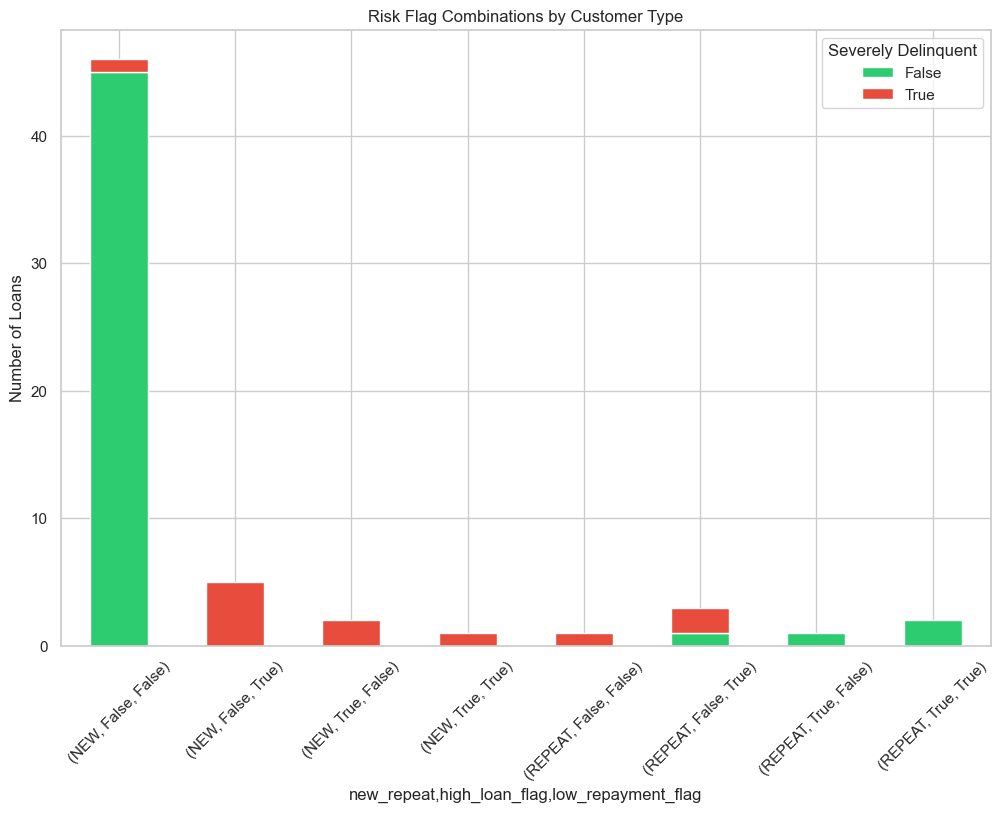

In [42]:
# Plot risk flag combinations
flag_counts = df.groupby(['new_repeat', 'high_loan_flag', 
                        'low_repayment_flag', 'severe_delinquency']).size().unstack()
flag_counts.plot(kind='bar', stacked=True, color=['#2ecc71','#e74c3c'])
plt.title('Risk Flag Combinations by Customer Type')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Severely Delinquent')
plt.show()

C:\Users\ELIZABETH\AppData\Local\Temp\ipykernel_20780\2908623645.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.set_index('Funded_date').resample('M').agg({


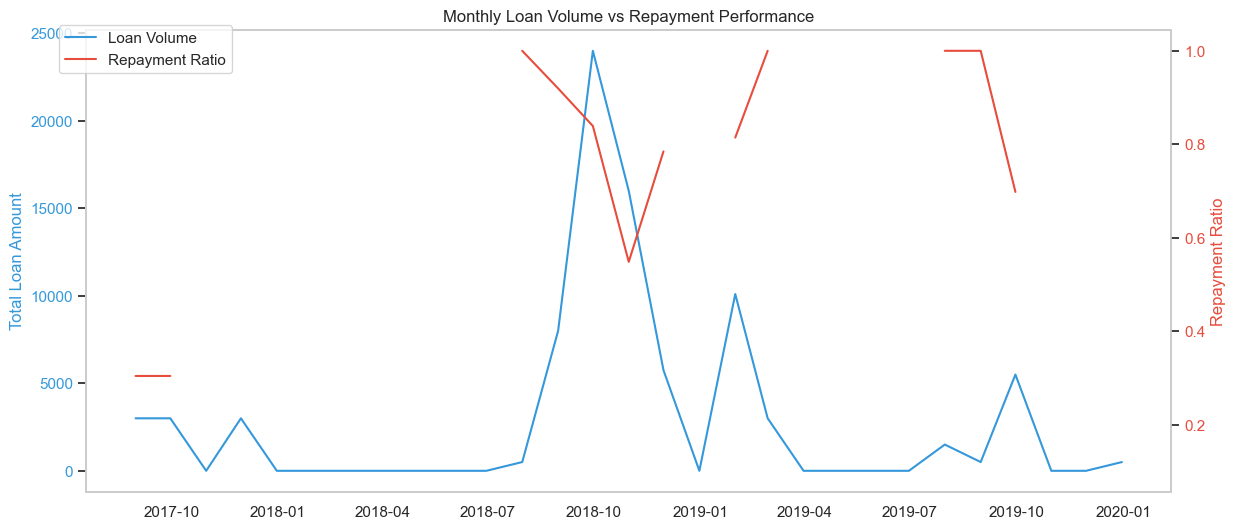

In [43]:
# Monthly Loan Volume vs Repayment Performance

monthly_data = df.set_index('Funded_date').resample('M').agg({
    'loan_amount': 'sum',
    'repayment_ratio': 'mean',
    'loan_status': lambda x: (x == 'Fully Repaid').mean()
})

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(monthly_data.index, monthly_data['loan_amount'], 
            color='#3498db', label='Loan Volume')
ax1.set_ylabel('Total Loan Amount', color='#3498db')
ax1.tick_params(axis='y', labelcolor='#3498db')

ax2 = ax1.twinx()
ax2.plot(monthly_data.index, monthly_data['repayment_ratio'], 
            color='#e74c3c', label='Repayment Ratio')
ax2.set_ylabel('Repayment Ratio', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

plt.title('Monthly Loan Volume vs Repayment Performance')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
ax1.grid(False)
ax2.grid(False)

plt.show()

C:\Users\ELIZABETH\AppData\Local\Temp\ipykernel_20780\2683703657.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_default_rates = df.set_index('Funded_date').resample('M').apply(


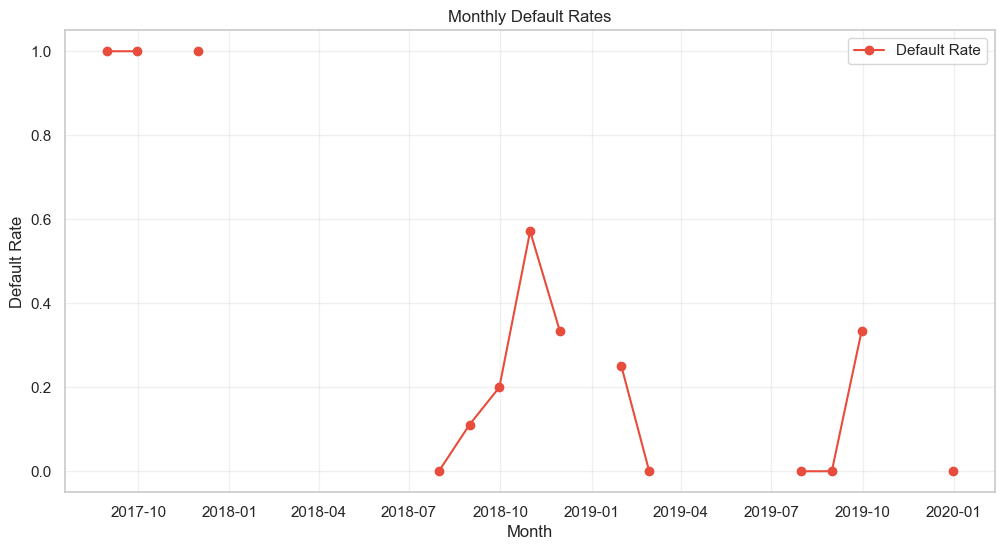

In [44]:
# Monthly Default Rates
monthly_default_rates = df.set_index('Funded_date').resample('M').apply(
    lambda x: (x['loan_status'] == 'Outstanding').mean()
)

plt.figure(figsize=(12, 6))
plt.plot(monthly_default_rates.index, monthly_default_rates.values, marker='o', color='#e74c3c', label='Default Rate')
plt.title('Monthly Default Rates')
plt.xlabel('Month')
plt.ylabel('Default Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Insights:

1. Repeat customers have 0% full repayment rate vs 83.3% for new customers
2. Average repayment ratio for repeat customers is only 20.7% vs 87.3% for new
3. Large loans (>$2,000) have 5.5x higher default risk
4. Loans paid due date have 95.1% default rate. Only 4.9% past due date were fully paid

Recommendations:

1. Implement stricter credit limits for repeat customers
2. Flag loans with: amount > $2,000, repayment < 30%, or delinquency > 30 days
3. Develop early warning system for loans approaching due date
4. Consider dynamic pricing based on repayment behavior (new customers)
5. Focus collections efforts on high-risk segments (repeat + large loans)